## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical
from sklearn.preprocessing import StandardScaler

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1, 3, 4, 5, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:400]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
def plot_generated_scenarios(scenarios, title="Generated Scenarios", num_samples=10):
    """
    Plot a sample of generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      num_samples (int): Number of scenarios to randomly sample and plot.
    """
    # Sample a few scenarios to avoid overcrowding the plot.
    sample_indices = np.random.choice(scenarios.shape[0], size=min(num_samples, scenarios.shape[0]), replace=False)
    sampled_scenarios = scenarios[sample_indices, :]
    
    plt.figure(figsize=(12, 6))
    for scenario in sampled_scenarios:
        plt.plot(scenario, alpha=0.7)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

def plot_generated_distribution(scenarios, title="Distribution of Cumulative Returns", bins=500):
    """
    Plot the distribution of cumulative returns computed from the generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      bins (int): Number of bins for the histogram.
    """
    # Compute cumulative returns for each scenario.
    cumulative_returns = np.array([np.prod(1 + scenario) - 1 for scenario in scenarios])
    
    plt.figure(figsize=(10, 6))
    plt.hist(cumulative_returns, bins=bins, density=True, alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel("Cumulative Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


In [7]:
from OliviaGAN import OliviaGAN
from MarketGAN import MarketGAN
from FashionGAN import FashionGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = FashionGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

Training GANs:   0%|          | 0/6 [00:00<?, ?asset/s]

Training GAN for REEL...
[Epoch 0/600] [Batch 0/27] [D loss: 1.0537] [G loss: 11.4861] [Tail penalty: 0.1694] [Structure penalty: 0.0646]
[Epoch 0/600] [Batch 10/27] [D loss: 0.8385] [G loss: 6.4477] [Tail penalty: 0.0724] [Structure penalty: 0.0772]
[Epoch 0/600] [Batch 20/27] [D loss: 0.7228] [G loss: 3.3972] [Tail penalty: 0.0146] [Structure penalty: 0.0807]
[Epoch 1/600] [Batch 0/27] [D loss: 0.5769] [G loss: 3.0194] [Tail penalty: 0.0008] [Structure penalty: 0.0925]
[Epoch 1/600] [Batch 10/27] [D loss: 0.5770] [G loss: 2.4093] [Tail penalty: 0.0001] [Structure penalty: 0.0739]
[Epoch 1/600] [Batch 20/27] [D loss: 0.4830] [G loss: 2.7157] [Tail penalty: 0.0001] [Structure penalty: 0.0839]
[Epoch 2/600] [Batch 0/27] [D loss: 0.5001] [G loss: 2.2986] [Tail penalty: 0.0001] [Structure penalty: 0.0708]
[Epoch 2/600] [Batch 10/27] [D loss: 0.6005] [G loss: 2.3927] [Tail penalty: 0.0000] [Structure penalty: 0.0752]
[Epoch 2/600] [Batch 20/27] [D loss: 0.5529] [G loss: 2.0935] [Tail penal

Training GANs:  17%|█▋        | 1/6 [17:34<1:27:54, 1054.81s/asset]

Finished training GAN for REEL.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
Finished generating scenarios for REEL.

REEL: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for PE...
[Epoch 0/600] [Batch 0/27] [D loss: 0.5452] [G loss: 30.6568] [Tail penalty: 0.5358] [Structure penalty: 0.0473]
[Epoch 0/600] [Batch 10/27] [D loss: 0.7844] [G loss: 20.7576] [Tail penalty: 0.3489] [Structure penalty: 0.0583]
[Epoch 0/600] [Batch 20/27] [D loss: 0.5170] [G loss: 10.5682] [Tail penalty: 0.1662] [Structure penalty: 0.0586]
[Epoch 1/600] [Batch 0/27] [D loss: 0.5211] [G loss: 5.4584] [Tail penalty: 0.0782] [Structure penalty: 0.0495]
[Epoch 1/600] [Batch 10/27] [D loss: 0.6209] [G loss: 3.2414] [Tail penalty: 0.0373] [Structure penalty: 0.0485]
[Epoch 1/600] [Batch 20/27] [D loss: 0.5491] [G loss: 1.6693] [Tail penalty: 0.0067] [Structure penalty: 0.0528]
[Epoch 2/600] [Batch 0/27] [D loss: 0.6411] [G loss: 1.4547

Training GANs:  33%|███▎      | 2/6 [35:10<1:10:20, 1055.23s/asset]

Finished training GAN for PE.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Finished generating scenarios for PE.

PE: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for IG...
[Epoch 0/600] [Batch 0/27] [D loss: 1.8903] [G loss: 96.1858] [Tail penalty: 1.1208] [Structure penalty: 1.1470]
[Epoch 0/600] [Batch 10/27] [D loss: 0.4973] [G loss: 76.0673] [Tail penalty: 0.7419] [Structure penalty: 1.1680]
[Epoch 0/600] [Batch 20/27] [D loss: 0.5205] [G loss: 55.3426] [Tail penalty: 0.5097] [Structure penalty: 0.9032]
[Epoch 1/600] [Batch 0/27] [D loss: 0.6460] [G loss: 35.5403] [Tail penalty: 0.3046] [Structure penalty: 0.6194]
[Epoch 1/600] [Batch 10/27] [D loss: 0.8845] [G loss: 21.4899] [Tail penalty: 0.1504] [Structure penalty: 0.4317]
[Epoch 1/600] [Batch 20/27] [D loss: 0.6783] [G loss: 13.3341] [Tail penalty: 0.0944] [Structure penalty: 0.2651]
[Epoch 2/600] [Batch 0/27] [D loss: 0.8295] [G loss: 8.6889] [Ta

Training GANs:  50%|█████     | 3/6 [52:43<52:42, 1054.09s/asset]  

Finished training GAN for IG.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Finished generating scenarios for IG.

IG: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for GOV...
[Epoch 0/600] [Batch 0/27] [D loss: 2.0802] [G loss: 91.0290] [Tail penalty: 1.4877] [Structure penalty: 0.3032]
[Epoch 0/600] [Batch 10/27] [D loss: 0.5430] [G loss: 77.9234] [Tail penalty: 1.2485] [Structure penalty: 0.3038]
[Epoch 0/600] [Batch 20/27] [D loss: 0.7866] [G loss: 56.0517] [Tail penalty: 0.8449] [Structure penalty: 0.3145]
[Epoch 1/600] [Batch 0/27] [D loss: 1.1908] [G loss: 41.3463] [Tail penalty: 0.5847] [Structure penalty: 0.3026]
[Epoch 1/600] [Batch 10/27] [D loss: 0.5501] [G loss: 31.5418] [Tail penalty: 0.4171] [Structure penalty: 0.2820]
[Epoch 1/600] [Batch 20/27] [D loss: 0.8877] [G loss: 22.2295] [Tail penalty: 0.2622] [Structure penalty: 0.2569]
[Epoch 2/600] [Batch 0/27] [D loss: 0.6808] [G loss: 18.4421] [

Training GANs:  67%|██████▋   | 4/6 [1:10:11<35:03, 1051.95s/asset]

Finished training GAN for GOV.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt
Finished generating scenarios for GOV.

GOV: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for HY...
[Epoch 0/600] [Batch 0/27] [D loss: 1.0144] [G loss: 21.4384] [Tail penalty: 0.2063] [Structure penalty: 0.3367]
[Epoch 0/600] [Batch 10/27] [D loss: 0.6721] [G loss: 14.6571] [Tail penalty: 0.0939] [Structure penalty: 0.3188]
[Epoch 0/600] [Batch 20/27] [D loss: 0.4035] [G loss: 11.3693] [Tail penalty: 0.0323] [Structure penalty: 0.3207]
[Epoch 1/600] [Batch 0/27] [D loss: 0.5057] [G loss: 5.1547] [Tail penalty: 0.0058] [Structure penalty: 0.1628]
[Epoch 1/600] [Batch 10/27] [D loss: 0.6133] [G loss: 2.9331] [Tail penalty: 0.0013] [Structure penalty: 0.0964]
[Epoch 1/600] [Batch 20/27] [D loss: 0.5289] [G loss: 2.8519] [Tail penalty: 0.0006] [Structure penalty: 0.0939]
[Epoch 2/600] [Batch 0/27] [D loss: 0.5704] [G loss: 3.2849] [T

Training GANs:  83%|████████▎ | 5/6 [1:27:52<17:35, 1055.25s/asset]

Finished training GAN for HY.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt
Finished generating scenarios for HY.

HY: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...
[Epoch 0/600] [Batch 0/27] [D loss: 30.0936] [G loss: 1153.8888] [Tail penalty: 1.8115] [Structure penalty: 35.1411]
[Epoch 0/600] [Batch 10/27] [D loss: 8.9994] [G loss: 778.1044] [Tail penalty: 1.4459] [Structure penalty: 23.2870]
[Epoch 0/600] [Batch 20/27] [D loss: 3.1842] [G loss: 386.4550] [Tail penalty: 1.1428] [Structure penalty: 10.7855]
[Epoch 1/600] [Batch 0/27] [D loss: 3.1881] [G loss: 171.5609] [Tail penalty: 0.9473] [Structure penalty: 3.9831]
[Epoch 1/600] [Batch 10/27] [D loss: 3.5446] [G loss: 73.8844] [Tail penalty: 0.7721] [Structure penalty: 1.0472]
[Epoch 1/600] [Batch 20/27] [D loss: 2.3211] [G loss: 51.9520] [Tail penalty: 0.6405] [Structure penalty: 0.5568]
[Epoch 2/600] [Batch 0/27] [D loss: 1.6650] [G loss:

Training GANs: 100%|██████████| 6/6 [1:45:13<00:00, 1052.25s/asset]

Finished training GAN for EONIA.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Finished generating scenarios for EONIA.

EONIA: Stored initial generated scenarios for 2019-12-31 00:00:00.


In [60]:
for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        print("date", test_day)

        # test different lookbacks
        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, 10, save=False, num_scenarios=10000)

        # plot_generated_distribution(scenarios=scenarios)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break

        print(f"{asset_name}: Generated new distribution on {test_day}.")

        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
    
    if foundNAN: break

Updating GANs:   0%|          | 0/6 [00:00<?, ?asset/s]

date 2020-01-02 00:00:00
REEL: Generated new distribution on 2020-01-02 00:00:00.
REEL: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
REEL: Generated new distribution on 2020-01-03 00:00:00.
REEL: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
REEL: Generated new distribution on 2020-01-06 00:00:00.
REEL: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
REEL: Generated new distribution on 2020-01-07 00:00:00.
REEL: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
REEL: Generated new distribution on 2020-01-08 00:00:00.
REEL: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
REEL: Generated new distribution on 2020-01-09 00:00:00.
REEL: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
REEL: Generated new distribution on 2020-01-10 00:00:00.
REEL: Stored generated scenarios for 2020-01-10 00:00:00.
date 2020-01-13 00:0

Updating GANs:  17%|█▋        | 1/6 [11:20<56:44, 680.80s/asset]

REEL: Generated new distribution on 2021-07-27 00:00:00.
REEL: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
PE: Generated new distribution on 2020-01-02 00:00:00.
PE: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
PE: Generated new distribution on 2020-01-03 00:00:00.
PE: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
PE: Generated new distribution on 2020-01-06 00:00:00.
PE: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
PE: Generated new distribution on 2020-01-07 00:00:00.
PE: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
PE: Generated new distribution on 2020-01-08 00:00:00.
PE: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
PE: Generated new distribution on 2020-01-09 00:00:00.
PE: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
PE: Generated new distribution on 2020-01-10

Updating GANs:  33%|███▎      | 2/6 [23:17<46:48, 702.13s/asset]

PE: Generated new distribution on 2021-07-27 00:00:00.
PE: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
IG: Generated new distribution on 2020-01-02 00:00:00.
IG: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
IG: Generated new distribution on 2020-01-03 00:00:00.
IG: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
IG: Generated new distribution on 2020-01-06 00:00:00.
IG: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
IG: Generated new distribution on 2020-01-07 00:00:00.
IG: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
IG: Generated new distribution on 2020-01-08 00:00:00.
IG: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
IG: Generated new distribution on 2020-01-09 00:00:00.
IG: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
IG: Generated new distribution on 2020-01-10 00:

Updating GANs:  50%|█████     | 3/6 [35:09<35:18, 706.26s/asset]

IG: Generated new distribution on 2021-07-27 00:00:00.
IG: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
GOV: Generated new distribution on 2020-01-02 00:00:00.
GOV: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
GOV: Generated new distribution on 2020-01-03 00:00:00.
GOV: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
GOV: Generated new distribution on 2020-01-06 00:00:00.
GOV: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
GOV: Generated new distribution on 2020-01-07 00:00:00.
GOV: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
GOV: Generated new distribution on 2020-01-08 00:00:00.
GOV: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
GOV: Generated new distribution on 2020-01-09 00:00:00.
GOV: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
GOV: Generated new distribution on 2

Updating GANs:  67%|██████▋   | 4/6 [46:55<23:32, 706.37s/asset]

GOV: Generated new distribution on 2021-07-27 00:00:00.
GOV: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
HY: Generated new distribution on 2020-01-02 00:00:00.
HY: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
HY: Generated new distribution on 2020-01-03 00:00:00.
HY: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
HY: Generated new distribution on 2020-01-06 00:00:00.
HY: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
HY: Generated new distribution on 2020-01-07 00:00:00.
HY: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
HY: Generated new distribution on 2020-01-08 00:00:00.
HY: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
HY: Generated new distribution on 2020-01-09 00:00:00.
HY: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
HY: Generated new distribution on 2020-01-10 0

Updating GANs:  83%|████████▎ | 5/6 [58:37<11:44, 704.87s/asset]

HY: Generated new distribution on 2021-07-27 00:00:00.
HY: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
EONIA: Generated new distribution on 2020-01-02 00:00:00.
EONIA: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
EONIA: Generated new distribution on 2020-01-03 00:00:00.
EONIA: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
EONIA: Generated new distribution on 2020-01-06 00:00:00.
EONIA: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
EONIA: Generated new distribution on 2020-01-07 00:00:00.
EONIA: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
EONIA: Generated new distribution on 2020-01-08 00:00:00.
EONIA: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
EONIA: Generated new distribution on 2020-01-09 00:00:00.
EONIA: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
EONIA: Gener

Updating GANs: 100%|██████████| 6/6 [1:10:29<00:00, 704.86s/asset]

EONIA: Generated new distribution on 2021-07-27 00:00:00.
EONIA: Stored generated scenarios for 2021-07-27 00:00:00.


In [61]:
returns_df.tail()

REEL        PE        IG       GOV        HY     EONIA
Date                                                                  
2019-12-23  0.000807 -0.006826 -0.000395 -0.000994  0.000516 -0.000045
2019-12-24  0.003047  0.001789  0.001135 -0.000096  0.000122 -0.000015
2019-12-27  0.012164  0.003310  0.001971  0.001809  0.000789 -0.000015
2019-12-30 -0.004847 -0.005184 -0.001701 -0.004516  0.000307 -0.000045
2019-12-31  0.002186 -0.000405 -0.000746  0.000056  0.000160 -0.000015

In [62]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [63]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

REEL        PE        IG       GOV        HY     EONIA
Date                                                                  
2021-07-21  0.017579  0.020856 -0.002522 -0.001919  0.001433 -0.000016
2021-07-22  0.002856  0.022455  0.001797  0.002519  0.000356 -0.000016
2021-07-23  0.000826  0.012661 -0.000580  0.000696  0.000374 -0.000016
2021-07-26 -0.000804  0.003743  0.000473 -0.000303  0.000157 -0.000047
2021-07-27  0.001020 -0.003492  0.001789  0.001112 -0.001467 -0.000016

In [64]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2021-07-27 00:00:00


REEL        PE        IG       GOV        HY    EONIA
Date                                                                 
2019-01-03  0.000449 -0.016792  0.003209 -0.002739  0.000322 -0.00001
2019-01-04  0.017480  0.029982 -0.004488 -0.002372  0.006997 -0.00001
2019-01-07  0.004902  0.016009  0.000024 -0.001484  0.006122 -0.00003
2019-01-08  0.015357  0.012384 -0.000592 -0.001053  0.004209 -0.00001
2019-01-09 -0.003836  0.003621  0.001019  0.001938  0.004650 -0.00001

In [65]:
historical_df.tail()

REEL        PE        IG       GOV        HY     EONIA
Date                                                                  
2021-07-21  0.017579  0.020856 -0.002522 -0.001919  0.001433 -0.000016
2021-07-22  0.002856  0.022455  0.001797  0.002519  0.000356 -0.000016
2021-07-23  0.000826  0.012661 -0.000580  0.000696  0.000374 -0.000016
2021-07-26 -0.000804  0.003743  0.000473 -0.000303  0.000157 -0.000047
2021-07-27  0.001020 -0.003492  0.001789  0.001112 -0.001467 -0.000016

In [66]:
entire_df.tail()

REEL        PE        IG       GOV        HY     EONIA
Date                                                                  
2021-07-21  0.017579  0.020856 -0.002522 -0.001919  0.001433 -0.000016
2021-07-22  0.002856  0.022455  0.001797  0.002519  0.000356 -0.000016
2021-07-23  0.000826  0.012661 -0.000580  0.000696  0.000374 -0.000016
2021-07-26 -0.000804  0.003743  0.000473 -0.000303  0.000157 -0.000047
2021-07-27  0.001020 -0.003492  0.001789  0.001112 -0.001467 -0.000016

# CASE 1

- We first calculate realized delta BOF for a given window

In [67]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


In [68]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [70]:
bof.loc["2019-12-31"]

np.float64(293698.80495503603)

In [71]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

Date 2019-12-31 00:00:00: SCR = -52478.25276541074
Date 2020-01-02 00:00:00: SCR = -58100.16039225257
Date 2020-01-03 00:00:00: SCR = -56222.3373970381
Date 2020-01-06 00:00:00: SCR = -58753.58223564783
Date 2020-01-07 00:00:00: SCR = -57620.51174019176
Date 2020-01-08 00:00:00: SCR = -59897.05117986996
Date 2020-01-09 00:00:00: SCR = -59060.434093586635
Date 2020-01-10 00:00:00: SCR = -59000.10676725064
Date 2020-01-13 00:00:00: SCR = -58110.18005396211
Date 2020-01-14 00:00:00: SCR = -57506.004042390145
Date 2020-01-15 00:00:00: SCR = -58305.103225701605
Date 2020-01-16 00:00:00: SCR = -60460.02921834942
Date 2020-01-17 00:00:00: SCR = -59333.28076637585
Date 2020-01-20 00:00:00: SCR = -58765.902117980346
Date 2020-01-21 00:00:00: SCR = -59409.72561399456
Date 2020-01-22 00:00:00: SCR = -59504.786339743965
Date 2020-01-23 00:00:00: SCR = -59792.171106688176
Date 2020-01-24 00:00:00: SCR = -59358.86251304944
Date 2020-01-27 00:00:00: SCR = -57765.20261799176


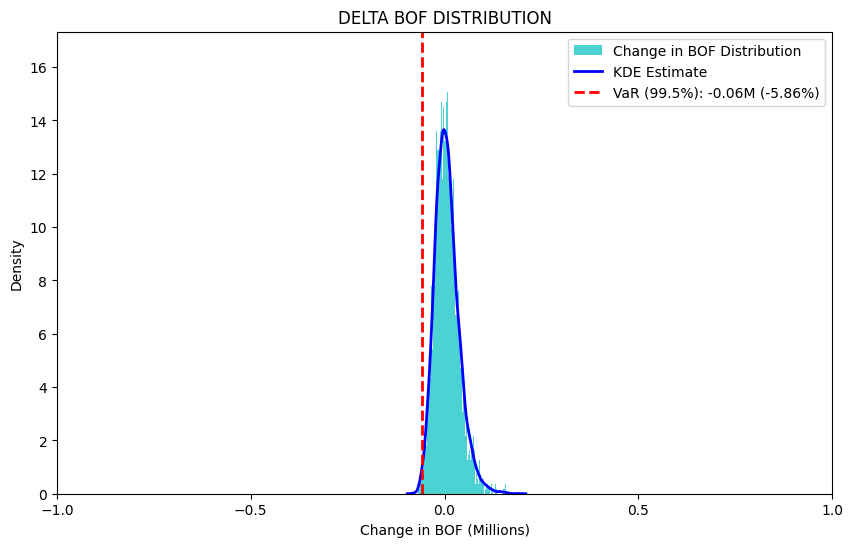

Date 2020-01-28 00:00:00: SCR = -58588.95899174376
Date 2020-01-29 00:00:00: SCR = -59745.051942764876
Date 2020-01-30 00:00:00: SCR = -59950.9160804621
Date 2020-01-31 00:00:00: SCR = -58347.78834145863
Date 2020-02-03 00:00:00: SCR = -60016.35549741108
Date 2020-02-04 00:00:00: SCR = -59195.81242272373
Date 2020-02-05 00:00:00: SCR = -61293.154243666366
Date 2020-02-06 00:00:00: SCR = -60095.3827775129
Date 2020-02-07 00:00:00: SCR = -58548.452366571466
Date 2020-02-10 00:00:00: SCR = -58193.66274598443
Date 2020-02-11 00:00:00: SCR = -59580.00782960895
Date 2020-02-12 00:00:00: SCR = -58880.785092147176
Date 2020-02-13 00:00:00: SCR = -59286.28532883004
Date 2020-02-14 00:00:00: SCR = -60344.36374982201
Date 2020-02-17 00:00:00: SCR = -59083.59427792871
Date 2020-02-18 00:00:00: SCR = -59887.069267228435
Date 2020-02-19 00:00:00: SCR = -58177.50635737423
Date 2020-02-20 00:00:00: SCR = -58095.53467591921
Date 2020-02-21 00:00:00: SCR = -57598.5678564676
Date 2020-02-24 00:00:00: SCR

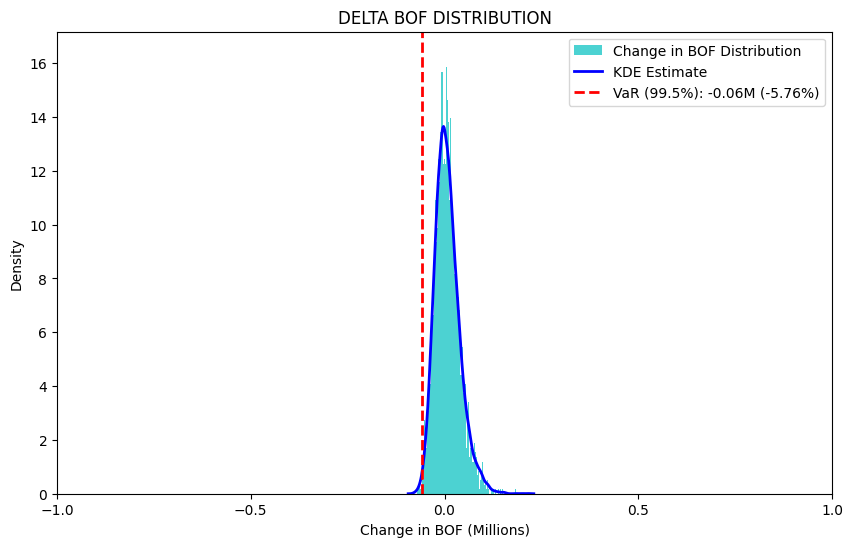

Date 2020-02-25 00:00:00: SCR = -57585.01209770516
Date 2020-02-26 00:00:00: SCR = -59784.6294511032
Date 2020-02-27 00:00:00: SCR = -60129.98159673053
Date 2020-02-28 00:00:00: SCR = -62814.00131696692
Date 2020-03-02 00:00:00: SCR = -63756.07050399144
Date 2020-03-03 00:00:00: SCR = -64138.74040788014
Date 2020-03-04 00:00:00: SCR = -64827.582881571376
Date 2020-03-05 00:00:00: SCR = -65985.19716489471
Date 2020-03-06 00:00:00: SCR = -65463.50429876641
Date 2020-03-09 00:00:00: SCR = -122461.7562959607
Date 2020-03-10 00:00:00: SCR = -136030.85656204217
Date 2020-03-11 00:00:00: SCR = -142769.94194500922
Date 2020-03-12 00:00:00: SCR = -204416.79907635046
Date 2020-03-13 00:00:00: SCR = -217392.8406017113
Date 2020-03-16 00:00:00: SCR = -225964.4500550397
Date 2020-03-17 00:00:00: SCR = -229897.36292787225
Date 2020-03-18 00:00:00: SCR = -231246.28039312366
Date 2020-03-19 00:00:00: SCR = -233086.0273049832
Date 2020-03-20 00:00:00: SCR = -234464.8054027589
Date 2020-03-23 00:00:00: 

Date 2020-03-24 00:00:00: SCR = -226407.6351481501
Date 2020-03-25 00:00:00: SCR = -219268.81948989545
Date 2020-03-26 00:00:00: SCR = -211338.82334351854
Date 2020-03-27 00:00:00: SCR = -205602.33124813714
Date 2020-03-30 00:00:00: SCR = -194625.16754399618
Date 2020-03-31 00:00:00: SCR = -187410.54167463296
Date 2020-04-01 00:00:00: SCR = -183396.92658930787
Date 2020-04-02 00:00:00: SCR = -178629.87807350472
Date 2020-04-03 00:00:00: SCR = -174652.68276012747
Date 2020-04-06 00:00:00: SCR = -174470.26783083272
Date 2020-04-07 00:00:00: SCR = -173048.85465263677
Date 2020-04-08 00:00:00: SCR = -170160.04517391836
Date 2020-04-09 00:00:00: SCR = -170463.39792701078
Date 2020-04-14 00:00:00: SCR = -167780.7148606523
Date 2020-04-15 00:00:00: SCR = -167267.1226821518
Date 2020-04-16 00:00:00: SCR = -166129.24727399822
Date 2020-04-17 00:00:00: SCR = -164880.2787003231
Date 2020-04-20 00:00:00: SCR = -163947.5818008104
Date 2020-04-21 00:00:00: SCR = -162104.042023503
Date 2020-04-22 00:

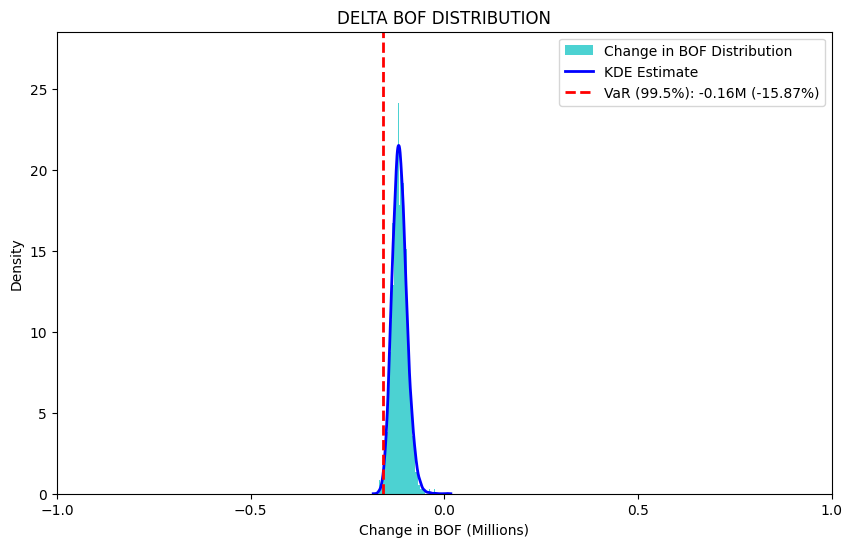

Date 2020-04-23 00:00:00: SCR = -158691.9975398541
Date 2020-04-24 00:00:00: SCR = -157628.65354064622
Date 2020-04-27 00:00:00: SCR = -157064.26564317694
Date 2020-04-28 00:00:00: SCR = -157313.7949148846
Date 2020-04-29 00:00:00: SCR = -155760.2991877206
Date 2020-04-30 00:00:00: SCR = -155677.76563878695
Date 2020-05-04 00:00:00: SCR = -155357.95895762448
Date 2020-05-05 00:00:00: SCR = -153984.63797005336
Date 2020-05-06 00:00:00: SCR = -154159.54623376217
Date 2020-05-07 00:00:00: SCR = -151492.8381410471
Date 2020-05-08 00:00:00: SCR = -152394.24141353916
Date 2020-05-11 00:00:00: SCR = -150488.8529545434
Date 2020-05-12 00:00:00: SCR = -149801.45887598034
Date 2020-05-13 00:00:00: SCR = -149440.6294328625
Date 2020-05-14 00:00:00: SCR = -148644.65186923338
Date 2020-05-15 00:00:00: SCR = -146827.06375791872
Date 2020-05-18 00:00:00: SCR = -146544.8382023366
Date 2020-05-19 00:00:00: SCR = -145751.89928150486
Date 2020-05-20 00:00:00: SCR = -146218.26615912755
Date 2020-05-21 00:

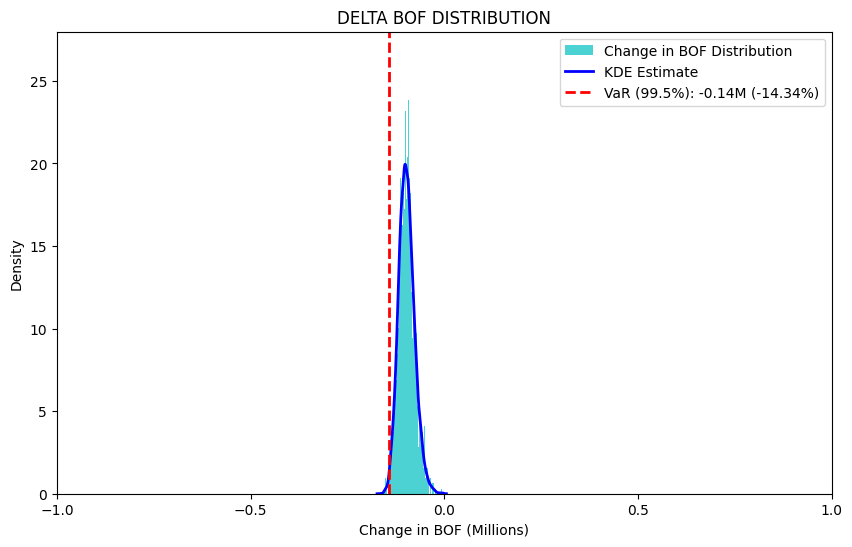

Date 2020-05-22 00:00:00: SCR = -143383.67781296413
Date 2020-05-25 00:00:00: SCR = -144072.27933039347
Date 2020-05-26 00:00:00: SCR = -143139.22600348154
Date 2020-05-27 00:00:00: SCR = -142597.98221441274
Date 2020-05-28 00:00:00: SCR = -142844.1281470394
Date 2020-05-29 00:00:00: SCR = -142510.76206351916
Date 2020-06-01 00:00:00: SCR = -142918.82239086155
Date 2020-06-02 00:00:00: SCR = -142042.04255382848
Date 2020-06-03 00:00:00: SCR = -141836.04371704106
Date 2020-06-04 00:00:00: SCR = -141773.23817430815
Date 2020-06-05 00:00:00: SCR = -141128.8970472304
Date 2020-06-08 00:00:00: SCR = -140713.00242863654
Date 2020-06-09 00:00:00: SCR = -139152.86161561008
Date 2020-06-10 00:00:00: SCR = -140010.12966452283
Date 2020-06-11 00:00:00: SCR = -138480.6566130193
Date 2020-06-12 00:00:00: SCR = -137242.90564376823
Date 2020-06-15 00:00:00: SCR = -135277.1502191607
Date 2020-06-16 00:00:00: SCR = -135251.5184577306
Date 2020-06-17 00:00:00: SCR = -135925.51088710467
Date 2020-06-18 0

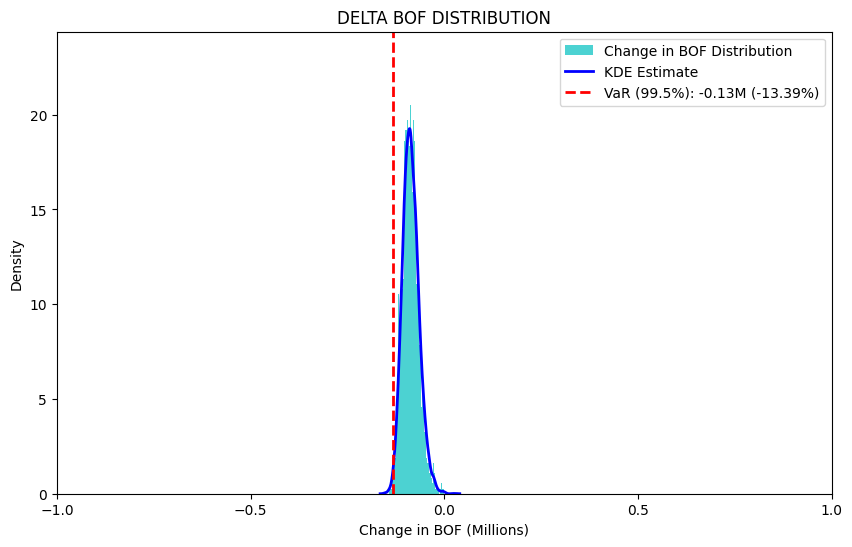

Date 2020-06-19 00:00:00: SCR = -133941.00512863795
Date 2020-06-22 00:00:00: SCR = -133404.37683080032
Date 2020-06-23 00:00:00: SCR = -133627.25293649666
Date 2020-06-24 00:00:00: SCR = -133713.18555765142
Date 2020-06-25 00:00:00: SCR = -132344.14497145973
Date 2020-06-26 00:00:00: SCR = -132278.4551779842
Date 2020-06-29 00:00:00: SCR = -132376.79730641682
Date 2020-06-30 00:00:00: SCR = -133925.11008011817
Date 2020-07-01 00:00:00: SCR = -133938.90868811918
Date 2020-07-02 00:00:00: SCR = -133139.76528410584
Date 2020-07-03 00:00:00: SCR = -132017.2519387754
Date 2020-07-06 00:00:00: SCR = -132666.98456615757
Date 2020-07-07 00:00:00: SCR = -131420.0282102775
Date 2020-07-08 00:00:00: SCR = -131826.2229269949
Date 2020-07-09 00:00:00: SCR = -131390.3080075328
Date 2020-07-10 00:00:00: SCR = -130638.91842562032
Date 2020-07-13 00:00:00: SCR = -131386.5685330073
Date 2020-07-14 00:00:00: SCR = -130986.91202255877
Date 2020-07-15 00:00:00: SCR = -131662.63032372785
Date 2020-07-16 00

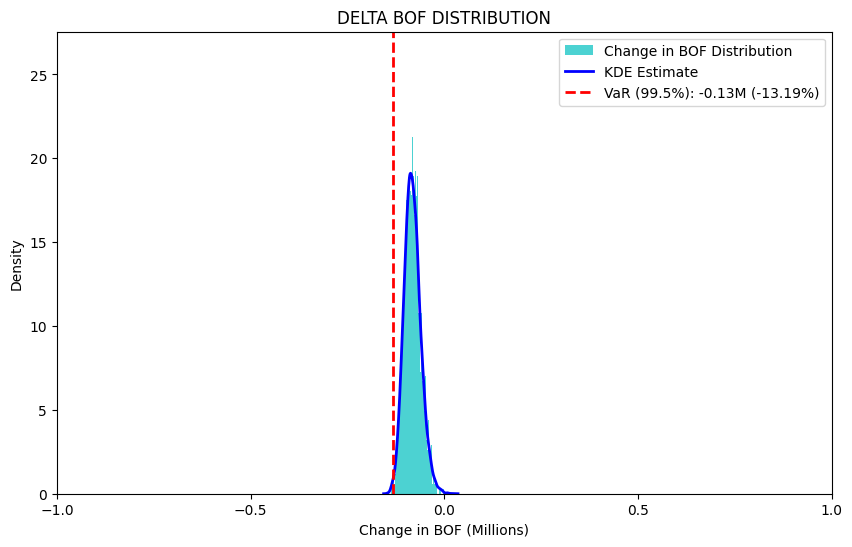

Date 2020-07-17 00:00:00: SCR = -131852.19444349606
Date 2020-07-20 00:00:00: SCR = -130484.43476342197
Date 2020-07-21 00:00:00: SCR = -130585.00145522109
Date 2020-07-22 00:00:00: SCR = -129109.34903280261
Date 2020-07-23 00:00:00: SCR = -129950.07521701172
Date 2020-07-24 00:00:00: SCR = -130228.34885858532
Date 2020-07-27 00:00:00: SCR = -128476.21413396831
Date 2020-07-28 00:00:00: SCR = -129760.02984888712
Date 2020-07-29 00:00:00: SCR = -129623.80878476457
Date 2020-07-30 00:00:00: SCR = -131464.58065103527
Date 2020-07-31 00:00:00: SCR = -130042.15656849225
Date 2020-08-03 00:00:00: SCR = -129208.73557267502
Date 2020-08-04 00:00:00: SCR = -130337.87541400595
Date 2020-08-05 00:00:00: SCR = -130376.4202518049
Date 2020-08-06 00:00:00: SCR = -130970.19618050249
Date 2020-08-07 00:00:00: SCR = -129574.3775243345
Date 2020-08-10 00:00:00: SCR = -130050.38297838214
Date 2020-08-11 00:00:00: SCR = -130558.73582396508
Date 2020-08-12 00:00:00: SCR = -129609.27592605913
Date 2020-08-1

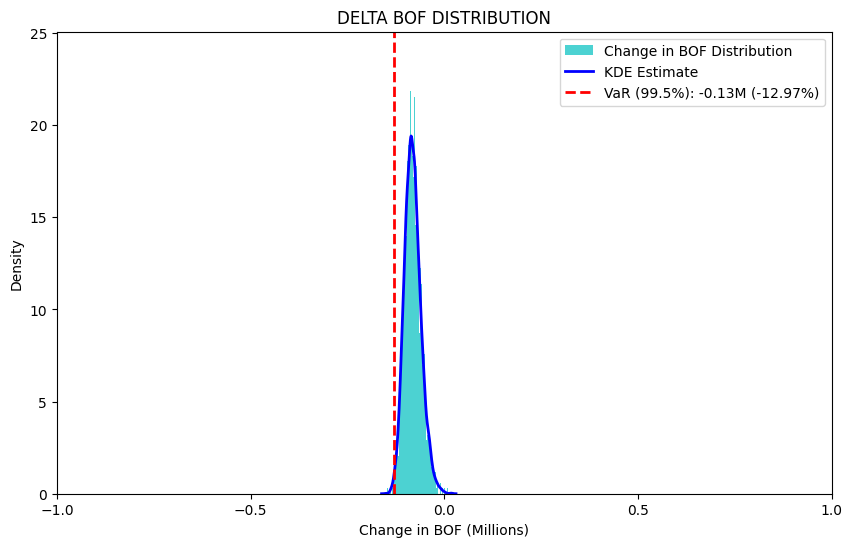

Date 2020-08-14 00:00:00: SCR = -129707.58248256365
Date 2020-08-17 00:00:00: SCR = -130063.77548997247
Date 2020-08-18 00:00:00: SCR = -130585.5803880437
Date 2020-08-19 00:00:00: SCR = -131244.06349992752
Date 2020-08-20 00:00:00: SCR = -130905.97304231965
Date 2020-08-21 00:00:00: SCR = -130111.28122147234
Date 2020-08-24 00:00:00: SCR = -131487.14024273233
Date 2020-08-25 00:00:00: SCR = -131355.28228562666
Date 2020-08-26 00:00:00: SCR = -131676.68223683038
Date 2020-08-27 00:00:00: SCR = -130056.66937887506
Date 2020-08-28 00:00:00: SCR = -131075.1871190929
Date 2020-08-31 00:00:00: SCR = -130883.53864180564
Date 2020-09-01 00:00:00: SCR = -130138.64194048563
Date 2020-09-02 00:00:00: SCR = -130890.97379262603
Date 2020-09-03 00:00:00: SCR = -129503.08014533036
Date 2020-09-04 00:00:00: SCR = -130616.52010239284
Date 2020-09-09 00:00:00: SCR = -131119.86489283244
Date 2020-09-10 00:00:00: SCR = -130485.48937356943
Date 2020-09-11 00:00:00: SCR = -128746.41862218852
Date 2020-09-1

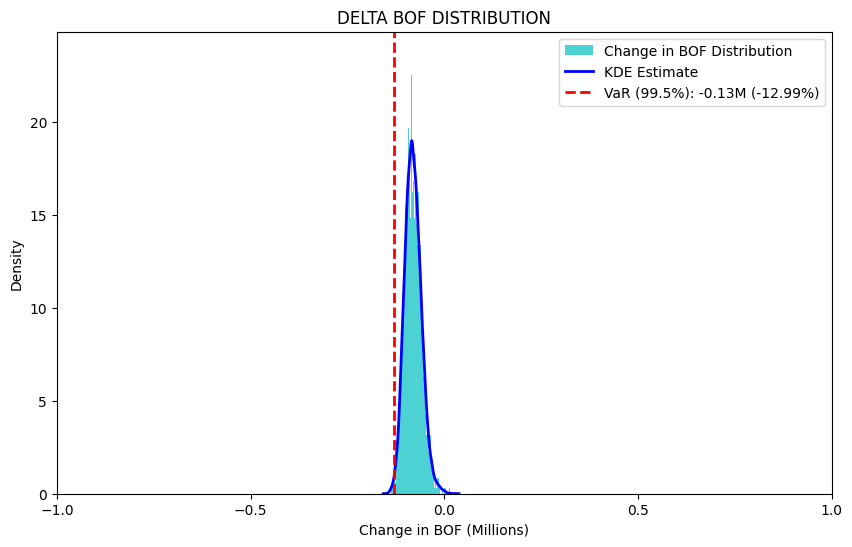

Date 2020-09-15 00:00:00: SCR = -129898.24094451912
Date 2020-09-16 00:00:00: SCR = -127008.5035377566
Date 2020-09-17 00:00:00: SCR = -128237.90909556074
Date 2020-09-18 00:00:00: SCR = -127020.85856814694
Date 2020-09-21 00:00:00: SCR = -127773.57340299603
Date 2020-09-22 00:00:00: SCR = -128828.50274174372
Date 2020-09-23 00:00:00: SCR = -128215.45194311769
Date 2020-09-24 00:00:00: SCR = -127950.67745290752
Date 2020-09-25 00:00:00: SCR = -128983.96543657617
Date 2020-09-28 00:00:00: SCR = -127374.29015967678
Date 2020-09-29 00:00:00: SCR = -127242.64881060917
Date 2020-09-30 00:00:00: SCR = -127009.96648394589
Date 2020-10-01 00:00:00: SCR = -125679.32940370242
Date 2020-10-02 00:00:00: SCR = -124896.7483882395
Date 2020-10-05 00:00:00: SCR = -126139.96033033053
Date 2020-10-06 00:00:00: SCR = -126161.28818735754
Date 2020-10-07 00:00:00: SCR = -125338.86614889136
Date 2020-10-08 00:00:00: SCR = -125080.52457786874
Date 2020-10-09 00:00:00: SCR = -125949.18193116187
Date 2020-10-1

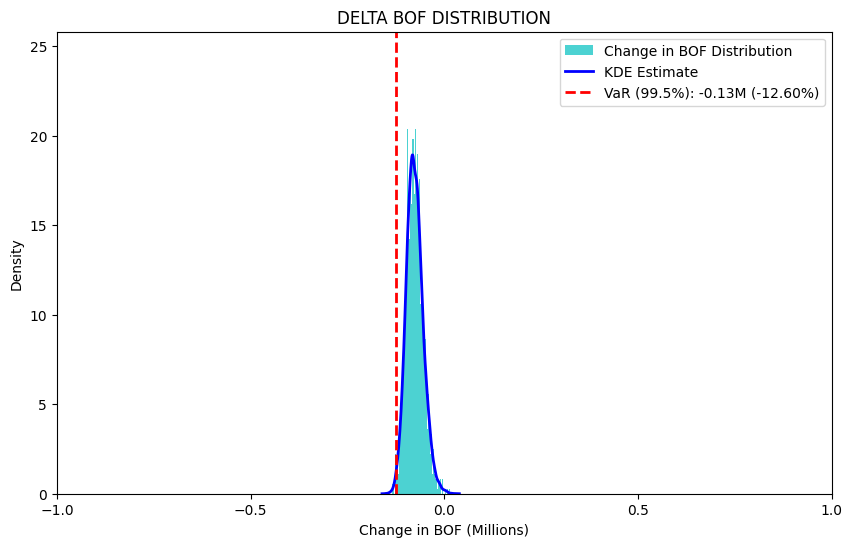

Date 2020-10-13 00:00:00: SCR = -126039.19271227201
Date 2020-10-14 00:00:00: SCR = -124845.13542198816
Date 2020-10-15 00:00:00: SCR = -125933.47416247685
Date 2020-10-16 00:00:00: SCR = -126688.87931091618
Date 2020-10-19 00:00:00: SCR = -125587.86967356363
Date 2020-10-20 00:00:00: SCR = -125764.07391802783
Date 2020-10-21 00:00:00: SCR = -126498.44691997838
Date 2020-10-22 00:00:00: SCR = -125744.76195882792
Date 2020-10-23 00:00:00: SCR = -125426.12590057691
Date 2020-10-26 00:00:00: SCR = -127283.20688647278
Date 2020-10-27 00:00:00: SCR = -124892.73440972638
Date 2020-10-28 00:00:00: SCR = -126220.90629508646
Date 2020-10-29 00:00:00: SCR = -125519.6886139361
Date 2020-10-30 00:00:00: SCR = -125019.87785724313
Date 2020-11-02 00:00:00: SCR = -124879.18882825851
Date 2020-11-03 00:00:00: SCR = -124589.47613642685
Date 2020-11-04 00:00:00: SCR = -124654.22868390719
Date 2020-11-05 00:00:00: SCR = -125388.08832121213
Date 2020-11-06 00:00:00: SCR = -124202.2610916519
Date 2020-11-0

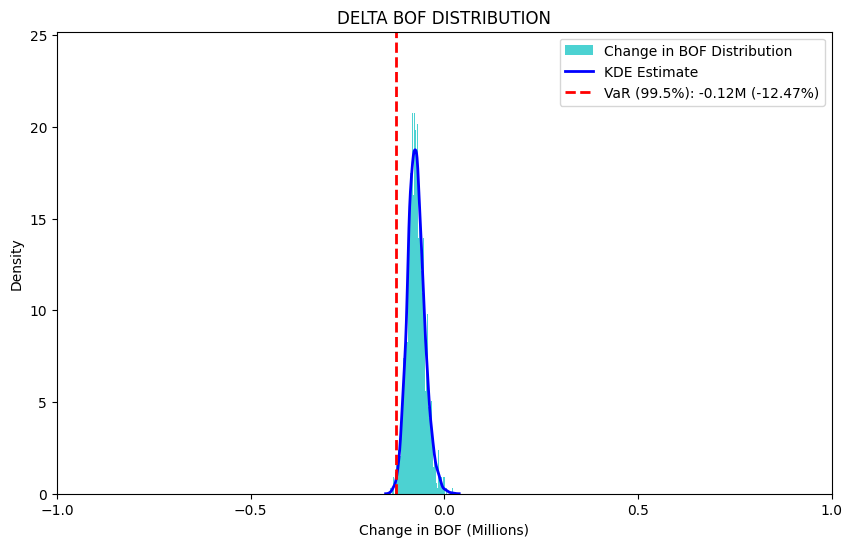

Date 2020-11-10 00:00:00: SCR = -124663.33657814021
Date 2020-11-11 00:00:00: SCR = -121933.72758262312
Date 2020-11-12 00:00:00: SCR = -123231.4190382766
Date 2020-11-13 00:00:00: SCR = -120934.23869999878
Date 2020-11-16 00:00:00: SCR = -121733.55140073458
Date 2020-11-17 00:00:00: SCR = -120240.52367590272
Date 2020-11-18 00:00:00: SCR = -121414.78933532388
Date 2020-11-19 00:00:00: SCR = -120388.73932682355
Date 2020-11-20 00:00:00: SCR = -119925.46199970877
Date 2020-11-23 00:00:00: SCR = -118304.39400443708
Date 2020-11-24 00:00:00: SCR = -120214.70798769004
Date 2020-11-25 00:00:00: SCR = -118664.42973896662
Date 2020-11-26 00:00:00: SCR = -119900.97839327173
Date 2020-11-27 00:00:00: SCR = -120041.36917576157
Date 2020-11-30 00:00:00: SCR = -120419.31107152939
Date 2020-12-01 00:00:00: SCR = -119525.32315038041
Date 2020-12-02 00:00:00: SCR = -120065.5878964965
Date 2020-12-03 00:00:00: SCR = -119786.32128143625
Date 2020-12-04 00:00:00: SCR = -119245.1919044844
Date 2020-12-07

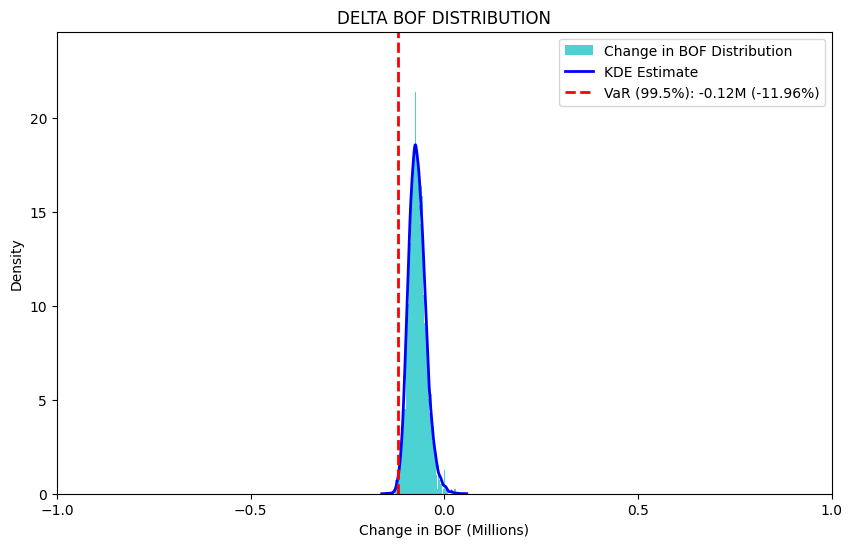

Date 2020-12-08 00:00:00: SCR = -119605.49901882804
Date 2020-12-09 00:00:00: SCR = -120723.65667387647
Date 2020-12-10 00:00:00: SCR = -119893.34816029225
Date 2020-12-11 00:00:00: SCR = -119454.61561922068
Date 2020-12-14 00:00:00: SCR = -120010.4875412782
Date 2020-12-15 00:00:00: SCR = -120637.43470749851
Date 2020-12-16 00:00:00: SCR = -121752.26324790005
Date 2020-12-17 00:00:00: SCR = -120399.59408254309
Date 2020-12-18 00:00:00: SCR = -123435.63864681871
Date 2020-12-21 00:00:00: SCR = -121264.37342522298
Date 2020-12-22 00:00:00: SCR = -120318.75174432754
Date 2020-12-23 00:00:00: SCR = -122228.02227642377
Date 2020-12-24 00:00:00: SCR = -121629.61380592354
Date 2020-12-28 00:00:00: SCR = -120396.70262097043
Date 2020-12-29 00:00:00: SCR = -121905.62454822862
Date 2020-12-30 00:00:00: SCR = -120919.4267696126
Date 2020-12-31 00:00:00: SCR = -122615.06098761555
Date 2021-01-04 00:00:00: SCR = -120993.90846199039
Date 2021-01-05 00:00:00: SCR = -119151.76992807392
Date 2021-01-0

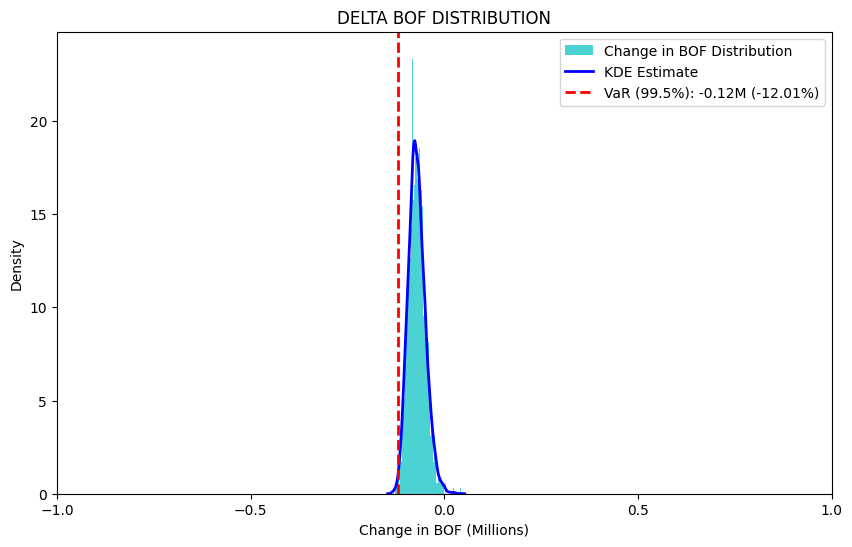

Date 2021-01-07 00:00:00: SCR = -120062.83667566617
Date 2021-01-08 00:00:00: SCR = -119657.64109097795
Date 2021-01-11 00:00:00: SCR = -121335.00160264014
Date 2021-01-12 00:00:00: SCR = -122265.83609293937
Date 2021-01-13 00:00:00: SCR = -120855.95080750146
Date 2021-01-14 00:00:00: SCR = -119619.45575659111
Date 2021-01-15 00:00:00: SCR = -120137.36856806758
Date 2021-01-18 00:00:00: SCR = -118866.90799541469
Date 2021-01-19 00:00:00: SCR = -120613.44215339032
Date 2021-01-20 00:00:00: SCR = -119519.9414288934
Date 2021-01-21 00:00:00: SCR = -120169.49249185566
Date 2021-01-22 00:00:00: SCR = -120414.32397925691
Date 2021-01-25 00:00:00: SCR = -119937.4048331865
Date 2021-01-26 00:00:00: SCR = -120215.41507942513
Date 2021-01-27 00:00:00: SCR = -119454.14543306983
Date 2021-01-28 00:00:00: SCR = -119302.75164217317
Date 2021-01-29 00:00:00: SCR = -120437.54889855377
Date 2021-02-01 00:00:00: SCR = -120046.41515334442
Date 2021-02-02 00:00:00: SCR = -119715.48376620615
Date 2021-02-0

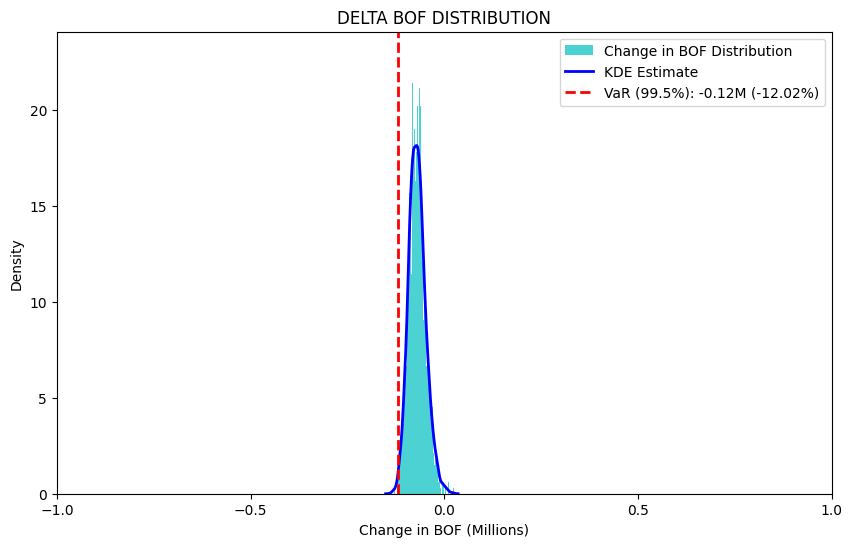

Date 2021-02-04 00:00:00: SCR = -120242.8438031864
Date 2021-02-05 00:00:00: SCR = -118744.78888342535
Date 2021-02-08 00:00:00: SCR = -120046.92582448001
Date 2021-02-09 00:00:00: SCR = -119213.65322902353
Date 2021-02-10 00:00:00: SCR = -120677.30952119506
Date 2021-02-11 00:00:00: SCR = -120231.30154527341
Date 2021-02-12 00:00:00: SCR = -119711.1820685863
Date 2021-02-15 00:00:00: SCR = -119812.49624694188
Date 2021-02-16 00:00:00: SCR = -119321.43113856314
Date 2021-02-17 00:00:00: SCR = -118901.54440447489
Date 2021-02-18 00:00:00: SCR = -119668.10495433806
Date 2021-02-19 00:00:00: SCR = -118810.4872531445
Date 2021-02-22 00:00:00: SCR = -119181.33950069113
Date 2021-02-23 00:00:00: SCR = -119821.14604193997
Date 2021-02-24 00:00:00: SCR = -120332.17527234077
Date 2021-02-25 00:00:00: SCR = -122045.14552504545
Date 2021-02-26 00:00:00: SCR = -122987.66494093572
Date 2021-03-01 00:00:00: SCR = -124491.3302518336
Date 2021-03-02 00:00:00: SCR = -121923.53287454283
Date 2021-03-03 

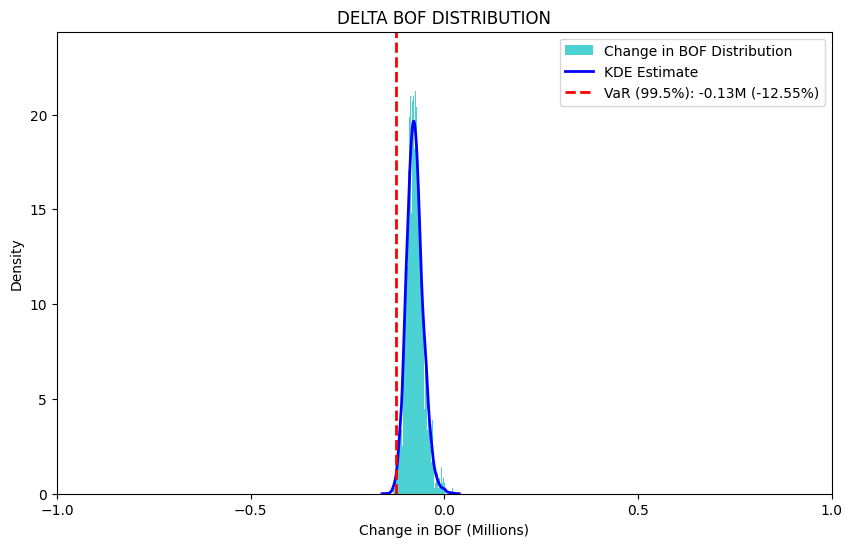

Date 2021-03-04 00:00:00: SCR = -125487.18182108871
Date 2021-03-05 00:00:00: SCR = -125326.88694832478
Date 2021-03-08 00:00:00: SCR = -128915.02704442335
Date 2021-03-09 00:00:00: SCR = -127476.97569080355
Date 2021-03-10 00:00:00: SCR = -127062.16956535343
Date 2021-03-11 00:00:00: SCR = -130023.75553139055
Date 2021-03-12 00:00:00: SCR = -128568.5348503017
Date 2021-03-15 00:00:00: SCR = -128196.93371550238
Date 2021-03-16 00:00:00: SCR = -127058.83119047801
Date 2021-03-17 00:00:00: SCR = -125179.23344864845
Date 2021-03-18 00:00:00: SCR = -124285.60887785601
Date 2021-03-19 00:00:00: SCR = -119044.57174491251
Date 2021-03-22 00:00:00: SCR = -111961.44313215569
Date 2021-03-23 00:00:00: SCR = -108672.16815718646
Date 2021-03-24 00:00:00: SCR = -103272.94701436674
Date 2021-03-25 00:00:00: SCR = -101437.94812805488
Date 2021-03-26 00:00:00: SCR = -100696.41121444061
Date 2021-03-29 00:00:00: SCR = -96937.02300742149
Date 2021-03-30 00:00:00: SCR = -92843.57167391137
Date 2021-03-31

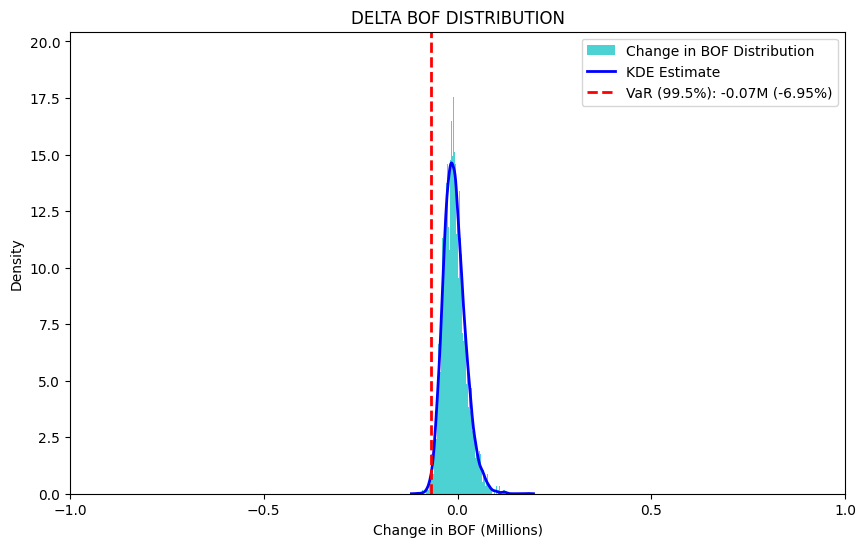

Date 2021-04-01 00:00:00: SCR = -69467.11346086183
Date 2021-04-06 00:00:00: SCR = -69174.23799993197
Date 2021-04-07 00:00:00: SCR = -70565.69334965706
Date 2021-04-08 00:00:00: SCR = -69171.47687694867
Date 2021-04-09 00:00:00: SCR = -66993.89439061156
Date 2021-04-12 00:00:00: SCR = -67716.64104520157
Date 2021-04-13 00:00:00: SCR = -68240.51766994479
Date 2021-04-14 00:00:00: SCR = -66512.07842002228
Date 2021-04-15 00:00:00: SCR = -66069.54282611847
Date 2021-04-16 00:00:00: SCR = -65364.69282561296
Date 2021-04-19 00:00:00: SCR = -62911.78422232624
Date 2021-04-20 00:00:00: SCR = -61348.36445086475
Date 2021-04-21 00:00:00: SCR = -59717.69954754193
Date 2021-04-22 00:00:00: SCR = -59734.038004411006
Date 2021-04-23 00:00:00: SCR = -60176.519713334994
Date 2021-04-26 00:00:00: SCR = -57878.28204517686
Date 2021-04-27 00:00:00: SCR = -57859.73902635888
Date 2021-04-28 00:00:00: SCR = -60374.963280127835
Date 2021-04-29 00:00:00: SCR = -58332.4761290963
Date 2021-04-30 00:00:00: SCR

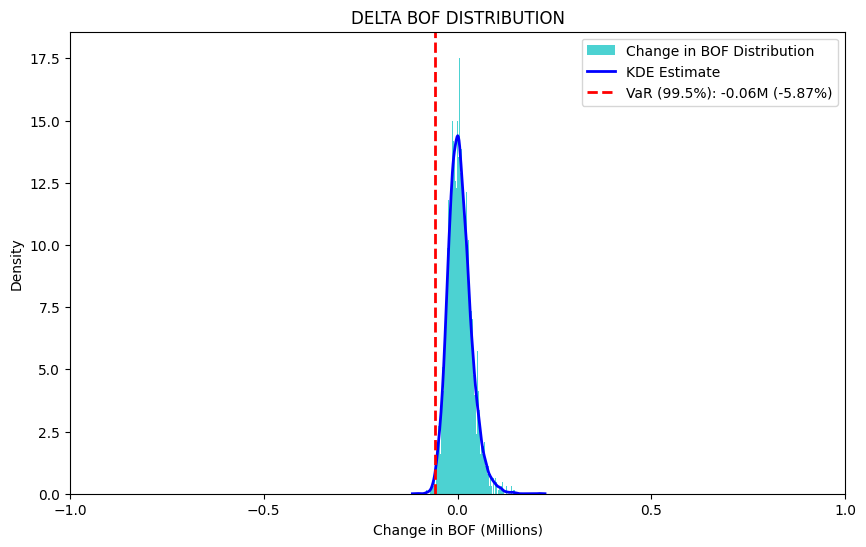

Date 2021-05-03 00:00:00: SCR = -58723.46008769345
Date 2021-05-04 00:00:00: SCR = -58201.36117323871
Date 2021-05-05 00:00:00: SCR = -61610.71225570669
Date 2021-05-06 00:00:00: SCR = -59279.16952781037
Date 2021-05-07 00:00:00: SCR = -59591.11187212936
Date 2021-05-10 00:00:00: SCR = -59160.68020046234
Date 2021-05-11 00:00:00: SCR = -60358.48294972101
Date 2021-05-12 00:00:00: SCR = -58713.77816491765
Date 2021-05-13 00:00:00: SCR = -60626.75320485428
Date 2021-05-14 00:00:00: SCR = -59367.26979044914
Date 2021-05-17 00:00:00: SCR = -60209.61283013664
Date 2021-05-18 00:00:00: SCR = -58463.05879444122
Date 2021-05-19 00:00:00: SCR = -59310.646902367225
Date 2021-05-20 00:00:00: SCR = -59285.75673596383
Date 2021-05-21 00:00:00: SCR = -58304.25919997219
Date 2021-05-24 00:00:00: SCR = -58945.02708714167
Date 2021-05-25 00:00:00: SCR = -61322.16157096541
Date 2021-05-26 00:00:00: SCR = -58667.2222967784
Date 2021-05-27 00:00:00: SCR = -61956.02036752065
Date 2021-05-28 00:00:00: SCR =

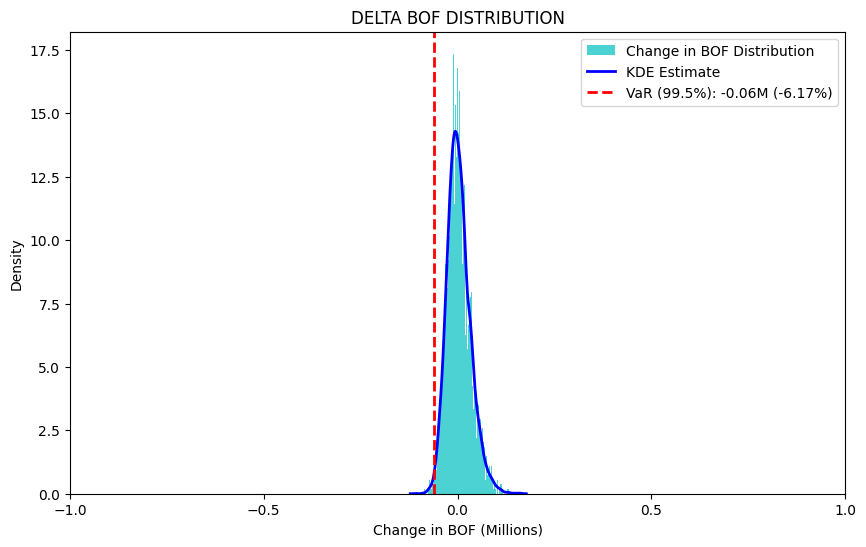

Date 2021-05-31 00:00:00: SCR = -61702.67844175973
Date 2021-06-01 00:00:00: SCR = -60517.18429704662
Date 2021-06-02 00:00:00: SCR = -61921.26210374189
Date 2021-06-03 00:00:00: SCR = -63745.52015467007
Date 2021-06-04 00:00:00: SCR = -61885.597360277214
Date 2021-06-07 00:00:00: SCR = -63311.429992523095
Date 2021-06-08 00:00:00: SCR = -63184.20230288501
Date 2021-06-09 00:00:00: SCR = -60395.87162177725
Date 2021-06-10 00:00:00: SCR = -61383.96004805565
Date 2021-06-11 00:00:00: SCR = -62572.59053048448
Date 2021-06-14 00:00:00: SCR = -61835.79156211221
Date 2021-06-15 00:00:00: SCR = -59104.73853517842
Date 2021-06-16 00:00:00: SCR = -57801.124470930095
Date 2021-06-17 00:00:00: SCR = -54502.33115010575
Date 2021-06-18 00:00:00: SCR = -56548.20891039852
Date 2021-06-21 00:00:00: SCR = -56184.89209165569
Date 2021-06-22 00:00:00: SCR = -53324.238317232106
Date 2021-06-23 00:00:00: SCR = -55574.1242395019
Date 2021-06-24 00:00:00: SCR = -54137.30519245151
Date 2021-06-25 00:00:00: SC

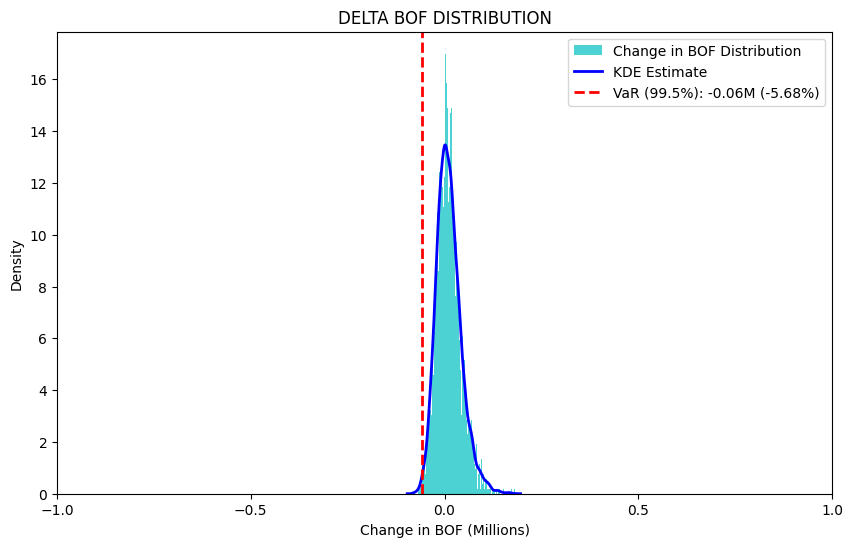

Date 2021-06-28 00:00:00: SCR = -56848.178499870264
Date 2021-06-29 00:00:00: SCR = -56203.34749236099
Date 2021-06-30 00:00:00: SCR = -56409.096227102316
Date 2021-07-01 00:00:00: SCR = -54589.971160198846
Date 2021-07-02 00:00:00: SCR = -57783.715918744325
Date 2021-07-05 00:00:00: SCR = -55955.52138600028
Date 2021-07-06 00:00:00: SCR = -56717.475102593104
Date 2021-07-07 00:00:00: SCR = -57276.61769042651
Date 2021-07-08 00:00:00: SCR = -55715.36584126467
Date 2021-07-09 00:00:00: SCR = -58101.18709704717
Date 2021-07-12 00:00:00: SCR = -57466.21006017366
Date 2021-07-13 00:00:00: SCR = -57815.36062825842
Date 2021-07-14 00:00:00: SCR = -56137.31391888297
Date 2021-07-15 00:00:00: SCR = -58059.74863780343
Date 2021-07-16 00:00:00: SCR = -56381.85064939181
Date 2021-07-19 00:00:00: SCR = -58943.29748988783
Date 2021-07-20 00:00:00: SCR = -57284.13999618534
Date 2021-07-21 00:00:00: SCR = -56015.77026656471
Date 2021-07-22 00:00:00: SCR = -56946.59902733481
Date 2021-07-23 00:00:00: 

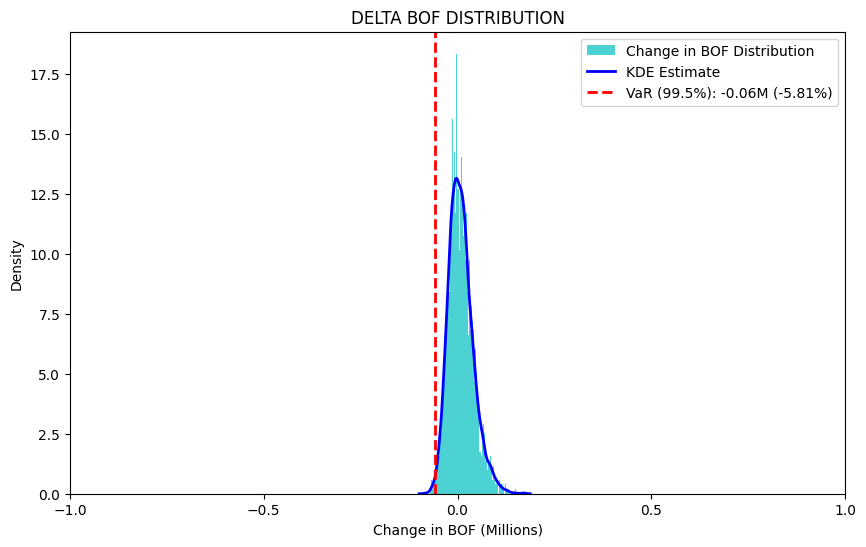

Date 2021-07-26 00:00:00: SCR = -58115.33331675847
Date 2021-07-27 00:00:00: SCR = -58583.7249206924


In [72]:
asset_names = list(returns_df.columns)

from utilities.bof_var_plot import plot_bof_var

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

i = 0
for date in all_dates[:]:
    i += 1
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        if np.isnan(asset_cum).any() or np.isinf(asset_cum).any():
            print(f"Warning: NaN or Inf encountered in cumulative returns for asset {asset} on date {date}.")
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    bof_change, scr = portfolio.calculate_distribution_and_scr(case=2)

    if i % 20 == 0 or i == 1:
        plot_bof_var(bof_change,scr,"DELTA BOF DISTRIBUTION")
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


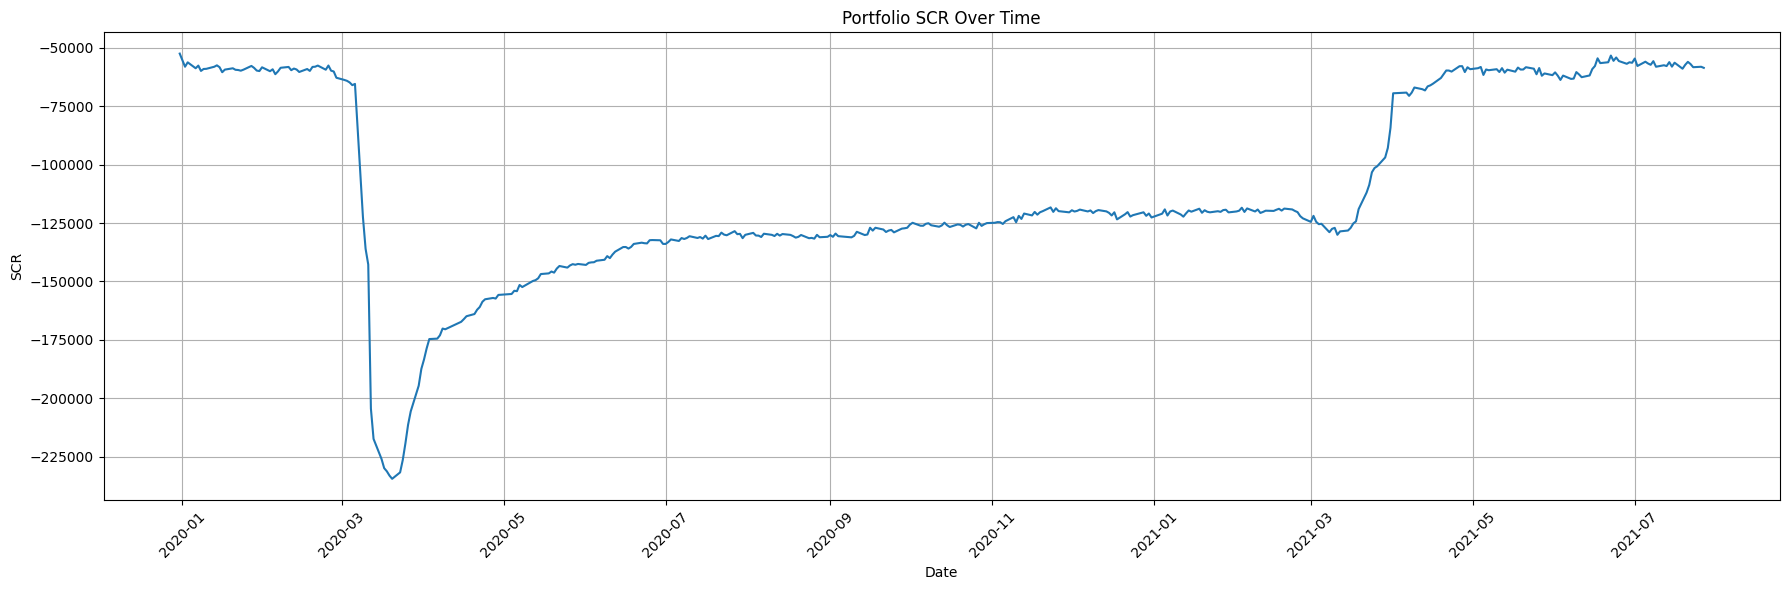

In [73]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Try out exponential weighting.

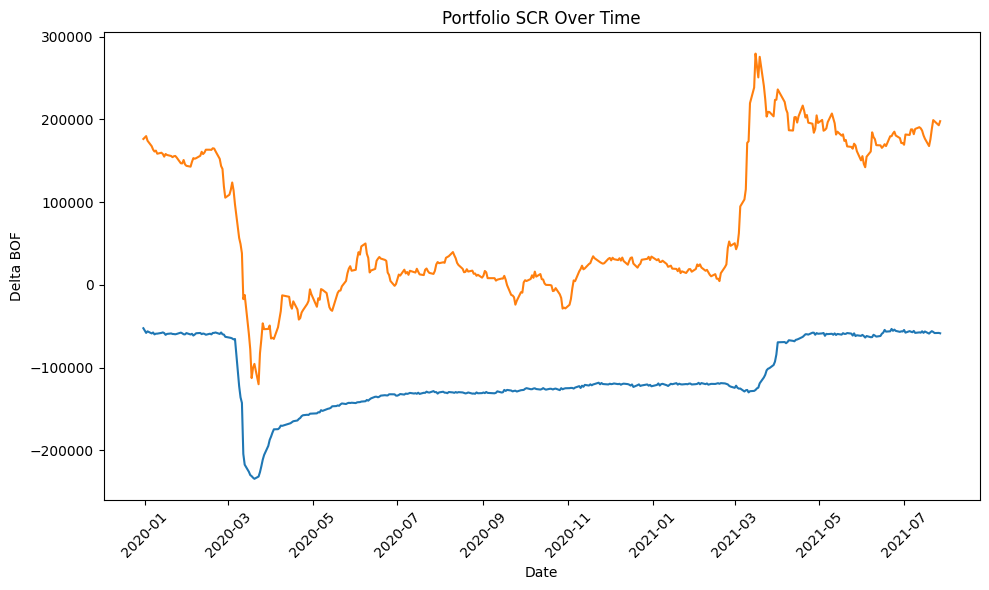

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Scaled = False


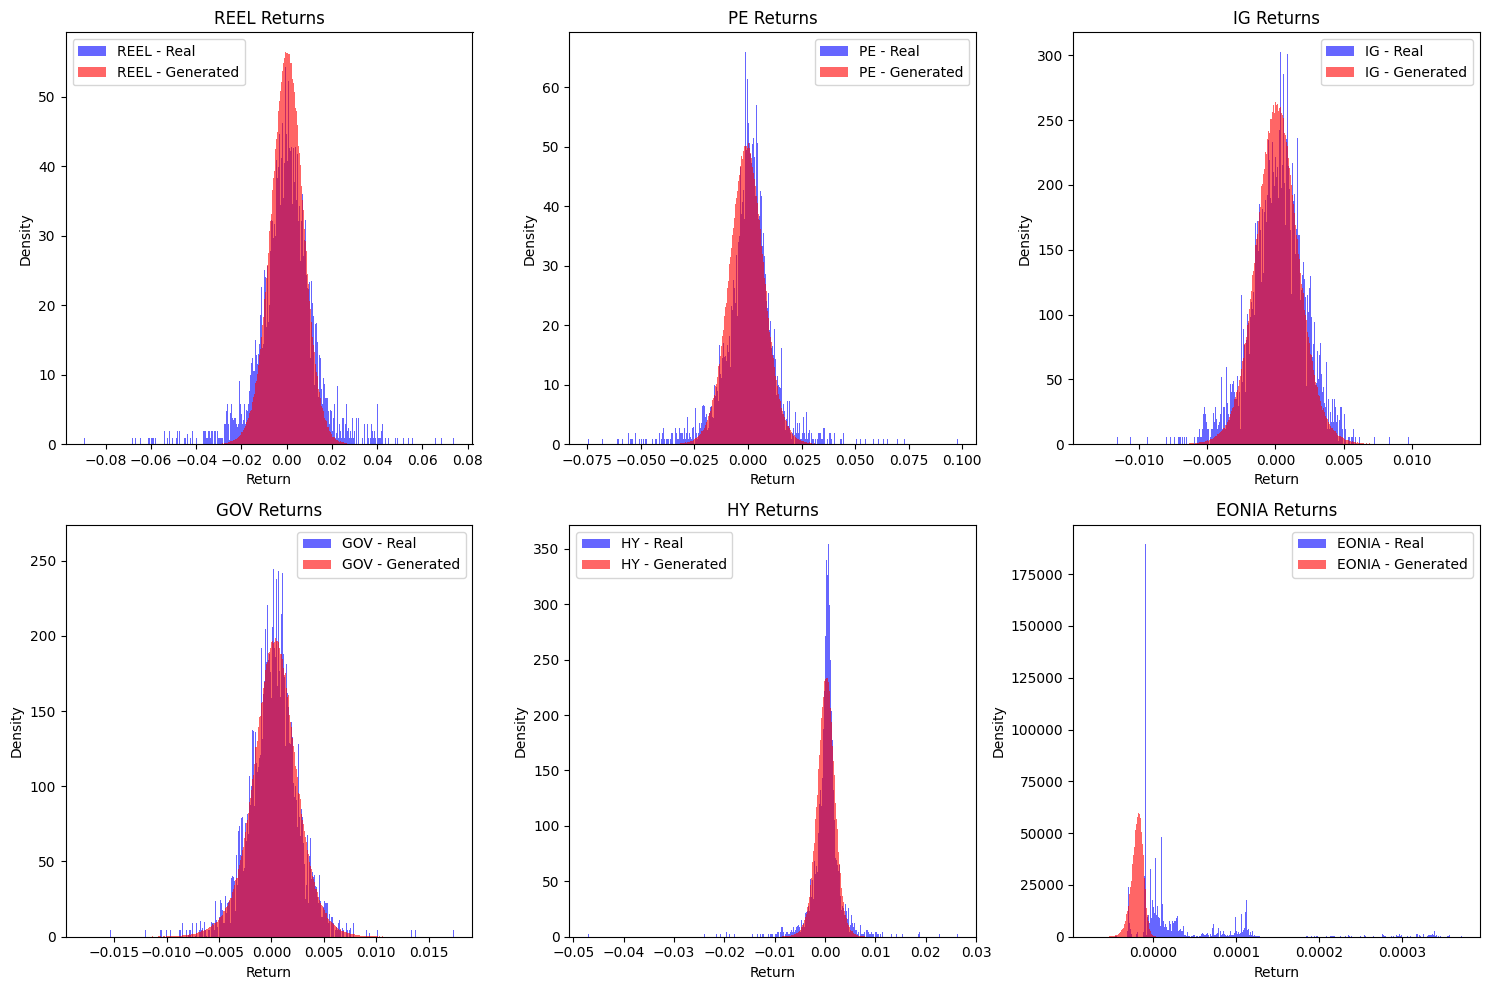


📊 Return Statistics Summary:
            Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
      REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
 REEL - Generated  0.000170 0.007321 -0.069113  0.283674  -0.019960
        PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
   PE - Generated -0.000657 0.008290  0.003653  0.484581  -0.023141
        IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
   IG - Generated  0.000146 0.001628  0.047911  0.760106  -0.004337
       GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
  GOV - Generated  0.000306 0.002267 -0.121544  1.074660  -0.006515
        HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
   HY - Generated  0.000204 0.001832 -0.139758  0.774414  -0.005180
     EONIA - Real  0.000032 0.000069  2.682698  8.158064  -0.000031
EONIA - Generated -0.000020 0.000007 -0.595024  0.977361  -0.000043



═══════════════════════════
║  ANALYZING ASSET: REEL  ║
═══════════════════════════

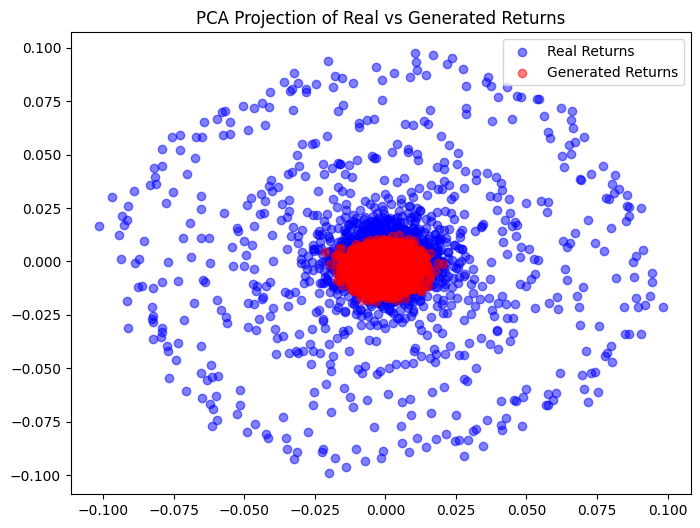

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt


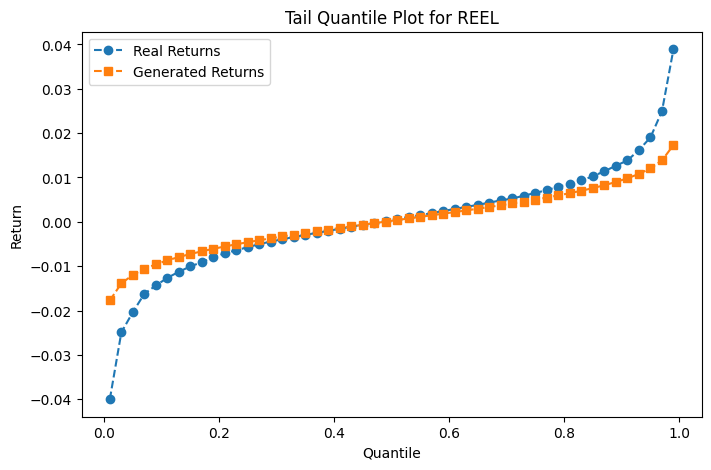


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 0.722929
Mean Distance: 0.001208
Median Distance: 0.000374
Standard Deviation: 0.003809


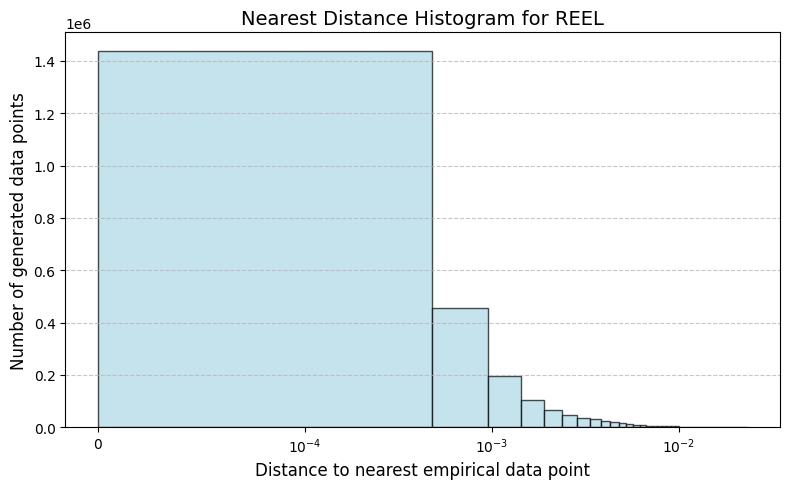


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.003110


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000064
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.177529
✅ Generated samples are reasonably diverse


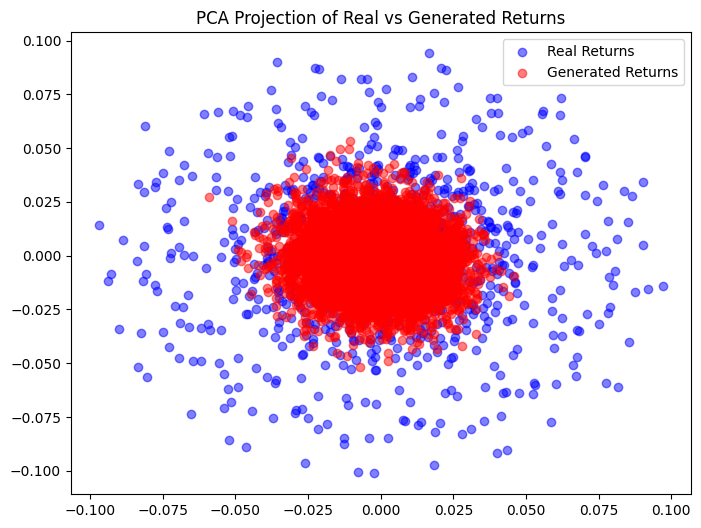

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt


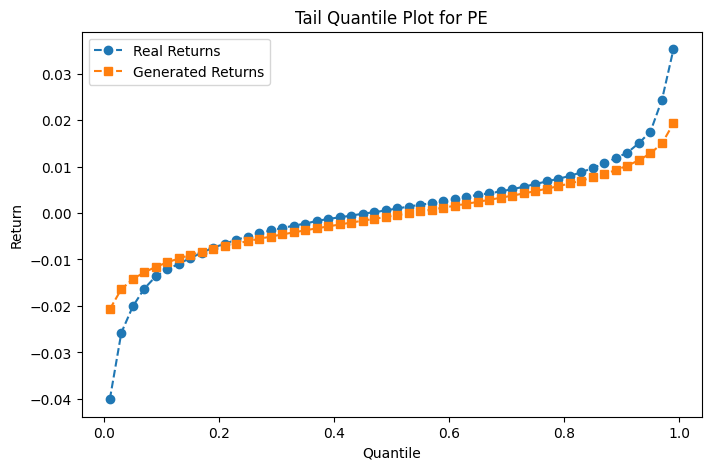


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 0.926867
Mean Distance: 0.001311
Median Distance: 0.000377
Standard Deviation: 0.005082


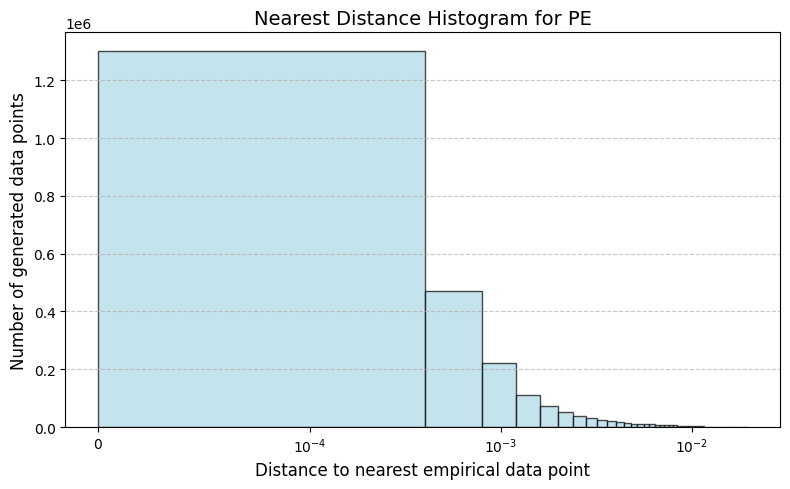


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.002773


═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000003
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.034781
✅ Generated samples are reasonably diverse


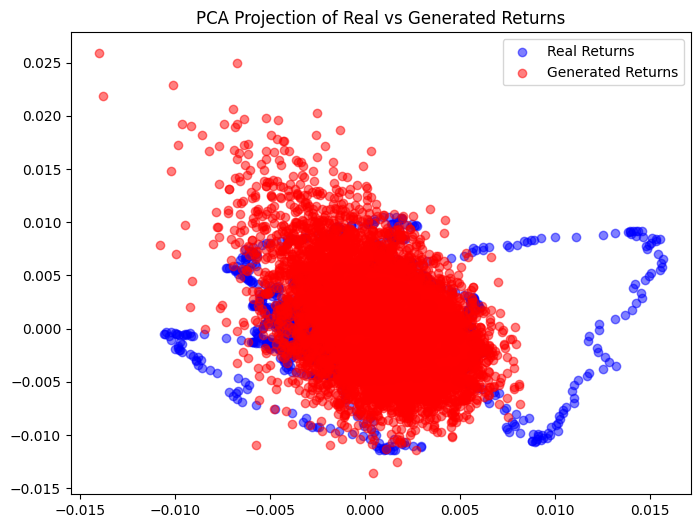

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt


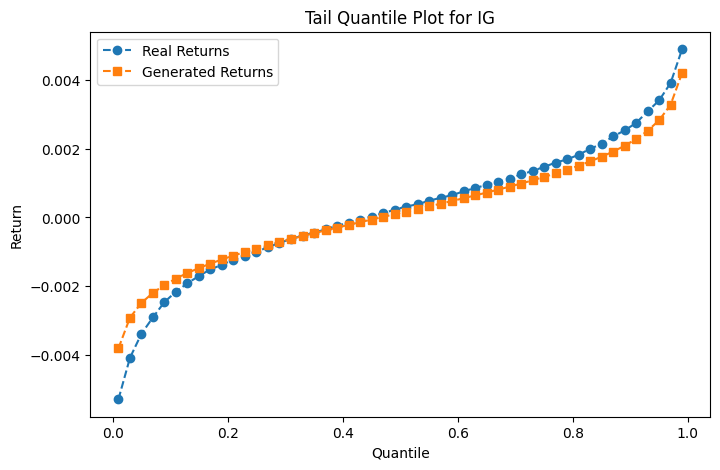


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 3.663617
Mean Distance: 0.001381
Median Distance: 0.000374
Standard Deviation: 0.012090


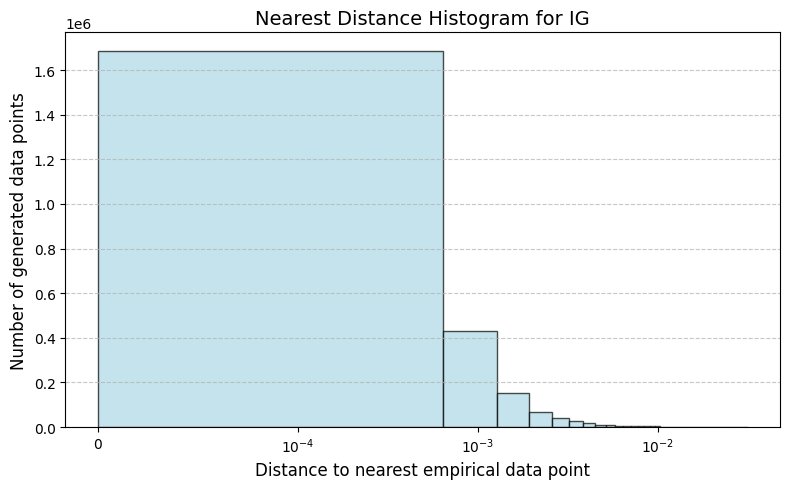


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000320


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt
Variance of Real Data: 0.000006
Variance of Generated Data: 0.000004
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.045895
✅ Generated samples are reasonably diverse


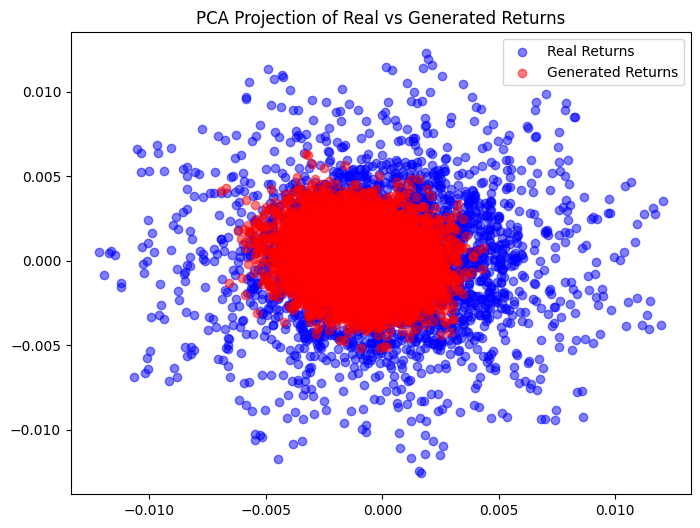

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt


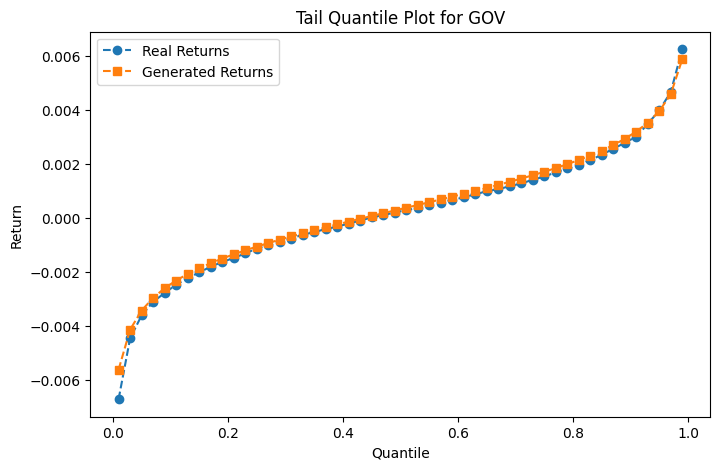


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt

📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 1.719750
Mean Distance: 0.001285
Median Distance: 0.000355
Standard Deviation: 0.007143


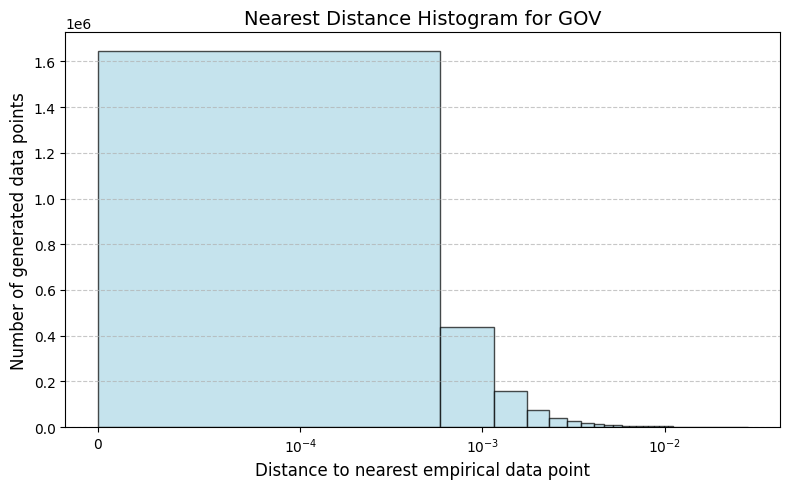


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_GOV_final_scenarios.pt
📊 Wasserstein Distance for GOV: 0.000169


═════════════════════════
║  ANALYZING ASSET: HY  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt
Variance of Real Data: 0.000009
Variance of Generated Data: 0.000002
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.060213
Mean Pairwise Distance (Generated): 0.033452
✅ Generated samples are reasonably diverse


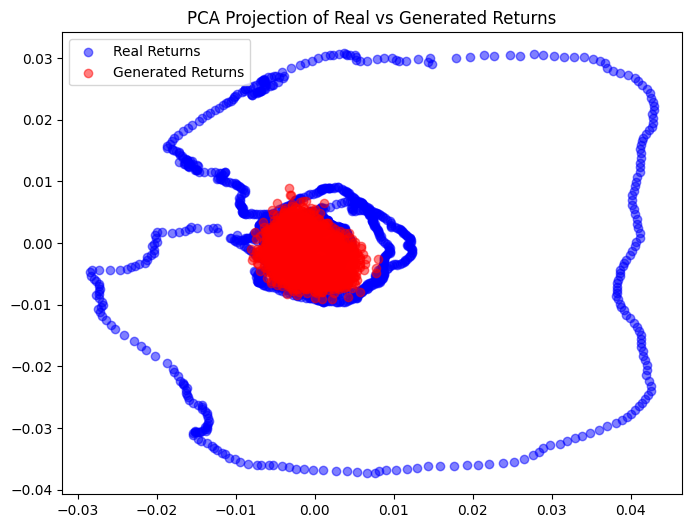

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt


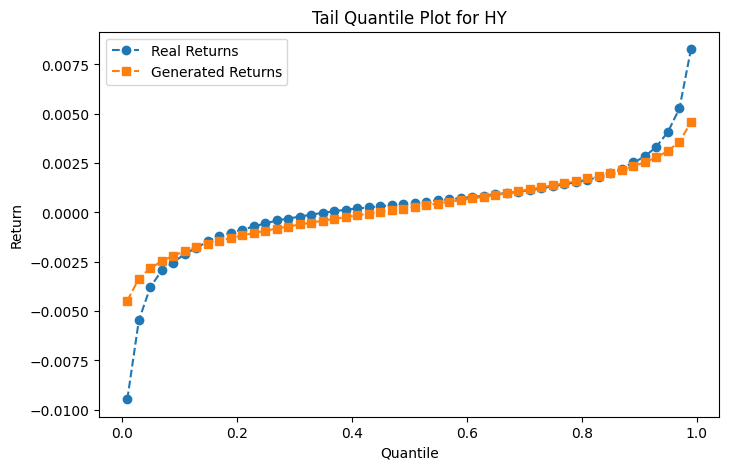


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: HY  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt

📊 Distance Summary for HY:
Min Distance: 0.000000
Max Distance: 0.472518
Mean Distance: 0.001641
Median Distance: 0.000407
Standard Deviation: 0.005154


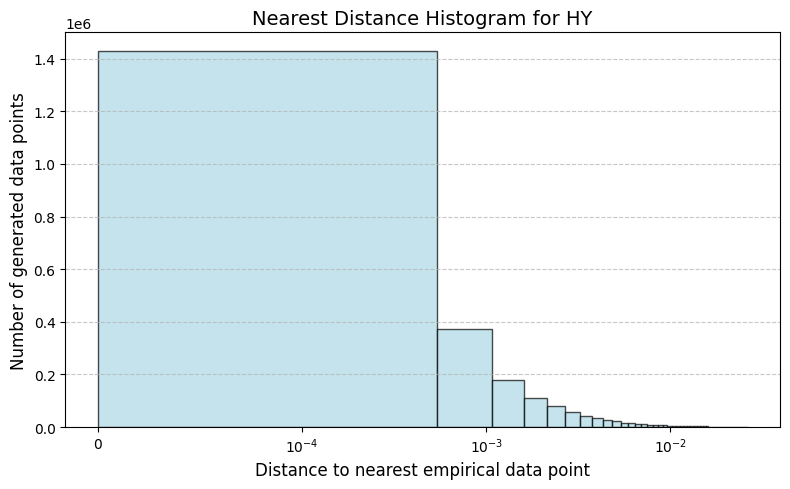


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: HY  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_HY_final_scenarios.pt
📊 Wasserstein Distance for HY: 0.000534


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.000151
⚠️ Warning: Potential Mode Collapse - Samples are too similar


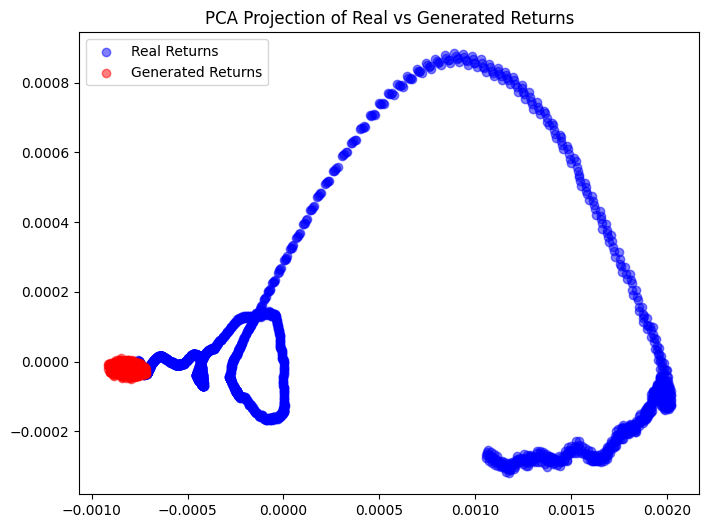


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000051



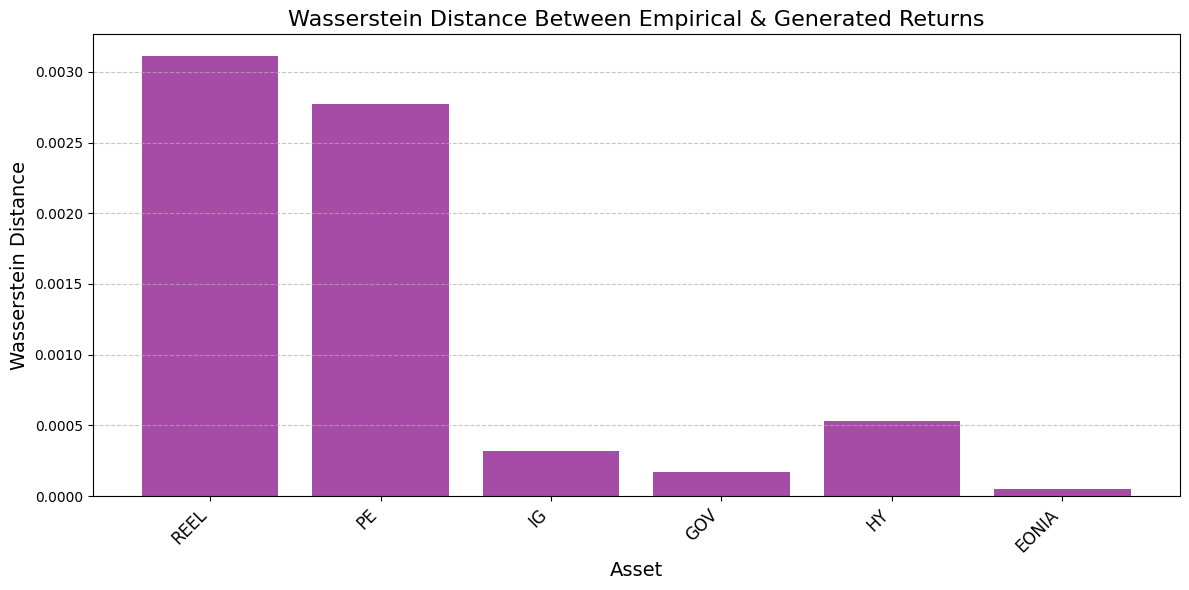

In [75]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

# ----------------------------------------------------------

In [76]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [77]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'